# EDA Demographique

In [3]:
import polars as pl
import pyarrow.parquet as pq
import sys

filepath = "../Data/processed/sirene_infos.parquet" 

print("--- Début de la lecture 'bypass' ---")

try:
    print(f"Lecture du fichier via PyArrow : {filepath}")
    table_arrow = pq.read_table(
        filepath,
    )
    
    print("Conversion de la table PyArrow en DataFrame Polars...")
    df_demo = pl.from_arrow(table_arrow)
    
    print("--- SUCCÈS ! ---\n")
    print("Le DataFrame est maintenant dans Polars, prêt pour la transformation.")
    print(df_demo.head())

except Exception as e:
    print(f"\n--- ERREUR ---", file=sys.stderr)
    print(f"Impossible de lire le fichier, même avec PyArrow : {e}", file=sys.stderr)

--- Début de la lecture 'bypass' ---
Lecture du fichier via PyArrow : ../Data/processed/sirene_infos.parquet
Conversion de la table PyArrow en DataFrame Polars...
--- SUCCÈS ! ---

Le DataFrame est maintenant dans Polars, prêt pour la transformation.
shape: (5, 15)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ siren     ┆ dateCreat ┆ dateFerme ┆ is_failed ┆ … ┆ moisCreat ┆ departeme ┆ trancheEf ┆ caracter │
│ ---       ┆ ionUniteL ┆ ture      ┆ _in_3y    ┆   ┆ ion       ┆ nt        ┆ fectifsSi ┆ eEmploye │
│ str       ┆ egale     ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ege       ┆ urSiege  │
│           ┆ ---       ┆ date      ┆ i32       ┆   ┆ i8        ┆ str       ┆ ---       ┆ ---      │
│           ┆ date      ┆           ┆           ┆   ┆           ┆           ┆ str       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 000325175 ┆ 2000-09-2 ┆ n

In [4]:
df_demo.schema

Schema([('siren', String),
        ('dateCreationUniteLegale', Date),
        ('dateFermeture', Date),
        ('is_failed_in_3y', Int32),
        ('categorieJuridiqueUniteLegale', Int64),
        ('trancheEffectifsUniteLegale', String),
        ('activitePrincipaleUniteLegale', String),
        ('categorieEntreprise', String),
        ('economieSocialeSolidaireUniteLegale', String),
        ('societeMissionUniteLegale', String),
        ('anneeCreation', Int32),
        ('moisCreation', Int8),
        ('departement', String),
        ('trancheEffectifsSiege', String),
        ('caractereEmployeurSiege', String)])

In [24]:
df_demo.describe()

statistic,siren,dateCreationUniteLegale,dateFermeture,is_failed_in_3y,categorieJuridiqueUniteLegale,trancheEffectifsUniteLegale,activitePrincipaleUniteLegale,categorieEntreprise,economieSocialeSolidaireUniteLegale,societeMissionUniteLegale,anneeCreation,moisCreation,departement,trancheEffectifsSiege,caractereEmployeurSiege,effective_end_date
str,str,str,str,f64,f64,str,str,str,str,str,f64,f64,str,str,str,str
"""count""","""10223433""","""10223433""","""432318""",1.0223433e7,1.0223433e7,"""10223433""","""10223433""","""10223433""","""10223433""","""10223433""",1.0223433e7,1.0223433e7,"""10223433""","""10223433""","""10223433""","""10223433"""
"""null_count""","""0""","""0""","""9791115""",0.0,0.0,"""0""","""0""","""0""","""0""","""0""",0.0,0.0,"""0""","""0""","""0""","""0"""
"""mean""",null,"""2012-06-08 22:07:57.438449""","""2018-11-30 19:07:51.502921""",0.008756,3056.154825,null,null,null,null,null,2011.980528,6.185161,null,null,null,"""2025-08-03 08:54:21.611867"""
"""std""",null,null,null,0.093165,2549.956592,null,null,null,null,null,11.055441,3.593599,null,null,null,null
"""min""","""000325175""","""1970-01-01""","""1971-04-19""",0.0,1000.0,"""00""","""00.00Z""","""ETI""","""INCONNU""","""INCONNU""",1970.0,1.0,""" D""","""00""","""N""","""1971-04-19"""
"""25%""",null,"""2007-05-10""","""2017-01-02""",0.0,1000.0,null,null,null,null,null,2007.0,3.0,null,null,null,"""2025-11-19"""
"""50%""",null,"""2016-02-01""","""2020-12-31""",0.0,1000.0,null,null,null,null,null,2016.0,6.0,null,null,null,"""2025-11-19"""
"""75%""",null,"""2021-02-11""","""2022-12-31""",0.0,5499.0,null,null,null,null,null,2021.0,9.0,null,null,null,"""2025-11-19"""
"""max""","""999992357""","""2025-11-01""","""2025-11-17""",1.0,9970.0,"""NN""","""99.00Z""","""PME""","""O""","""O""",2025.0,12.0,"""sw""","""NN""","""O""","""2025-11-19"""


In [10]:
from datetime import datetime
today = datetime.now()
df_demo = df_demo.with_columns(
    pl.when(pl.col("dateFermeture").is_not_null())
    .then(pl.col("dateFermeture"))
    .otherwise(pl.lit(today).cast(pl.Date)) # Use current date if active
    .alias("effective_end_date")
)

# Calculate duration in days then years
df_eta_hist = df_demo.with_columns(
    ((pl.col("effective_end_date") - pl.col("dateCreationUniteLegale")).dt.total_days() / 365.25).alias("age_years")
)

In [28]:
top_cats = df_demo["categorieJuridiqueUniteLegale"].value_counts().head(10)["categorieJuridiqueUniteLegale"]
top_cats

categorieJuridiqueUniteLegale
i64
2800
5599
7113
5426
7111
7346
7354
7112
7323


/var/folders/78/l_4xwnr90kd9z9r2bqrlqkqw0000gn/T/ipykernel_1591/12390573.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='is_failed_in_3y', data=df_demo, palette='viridis')


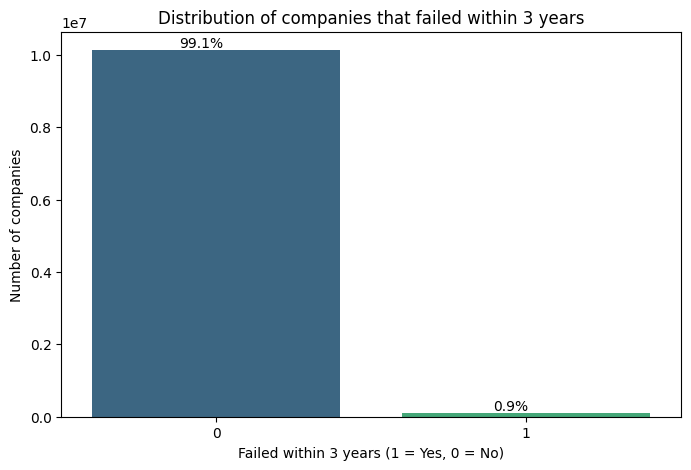

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Distribution de la variable cible
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='is_failed_in_3y', data=df_demo, palette='viridis')

plt.title('Distribution of companies that failed within 3 years')
plt.xlabel('Failed within 3 years (1 = Yes, 0 = No)')
plt.ylabel('Number of companies')

# Ajouter les pourcentages sur les barres
total = len(df_demo)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show() 

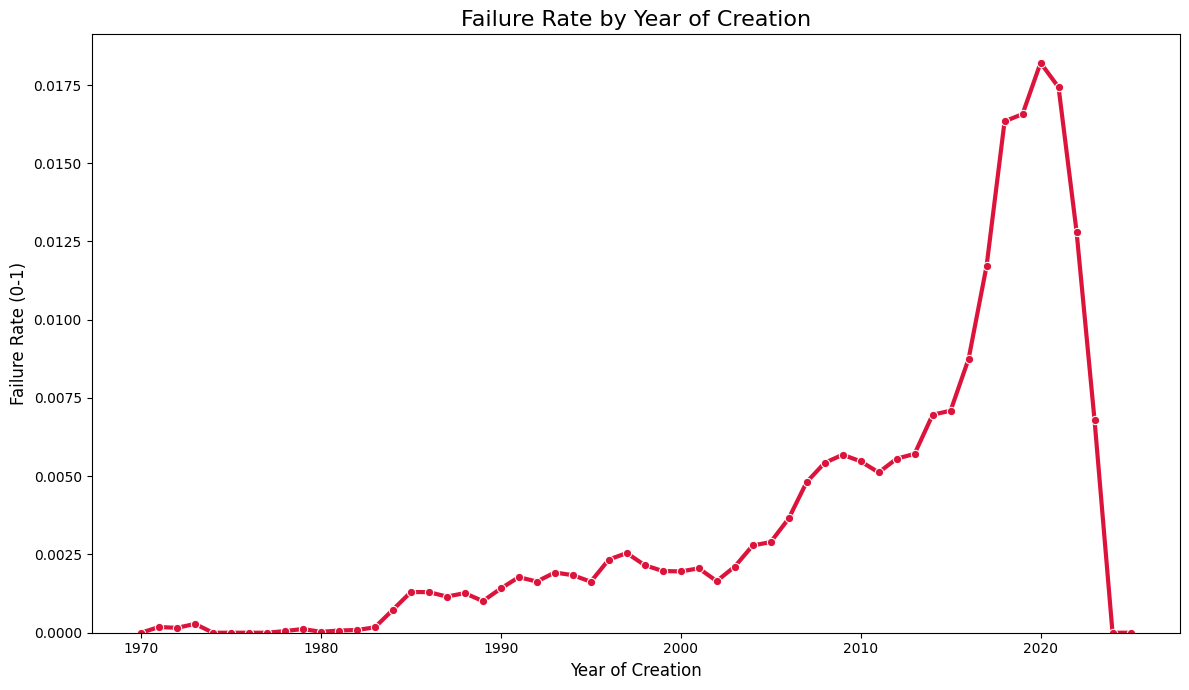

In [25]:
plt.figure(figsize=(12, 7))
yearly_risk = (
    df_demo.group_by("anneeCreation")
    .agg(pl.col("is_failed_in_3y").mean())
    .sort("anneeCreation")
).to_pandas()
sns.lineplot(x='anneeCreation', y='is_failed_in_3y', data=yearly_risk, marker='o', color='crimson', linewidth=3)
plt.title('Failure Rate by Year of Creation', fontsize=16)
plt.ylabel('Failure Rate (0-1)', fontsize=12)
plt.xlabel('Year of Creation', fontsize=12)
plt.ylim(0, None)
plt.tight_layout()
plt.savefig('graph_2_failure_by_year.png')
plt.show()

/var/folders/78/l_4xwnr90kd9z9r2bqrlqkqw0000gn/T/ipykernel_1591/78996366.py:4: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  cat_data = df_demo.filter(pl.col("categorieJuridiqueUniteLegale").is_in(top_cats)).to_pandas()
/var/folders/78/l_4xwnr90kd9z9r2bqrlqkqw0000gn/T/ipykernel_1591/78996366.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categorieJuridiqueUniteLegale', y='is_failed_in_3y', data=cat_data, order=order_jur, palette='Blues_d', errorbar=None)


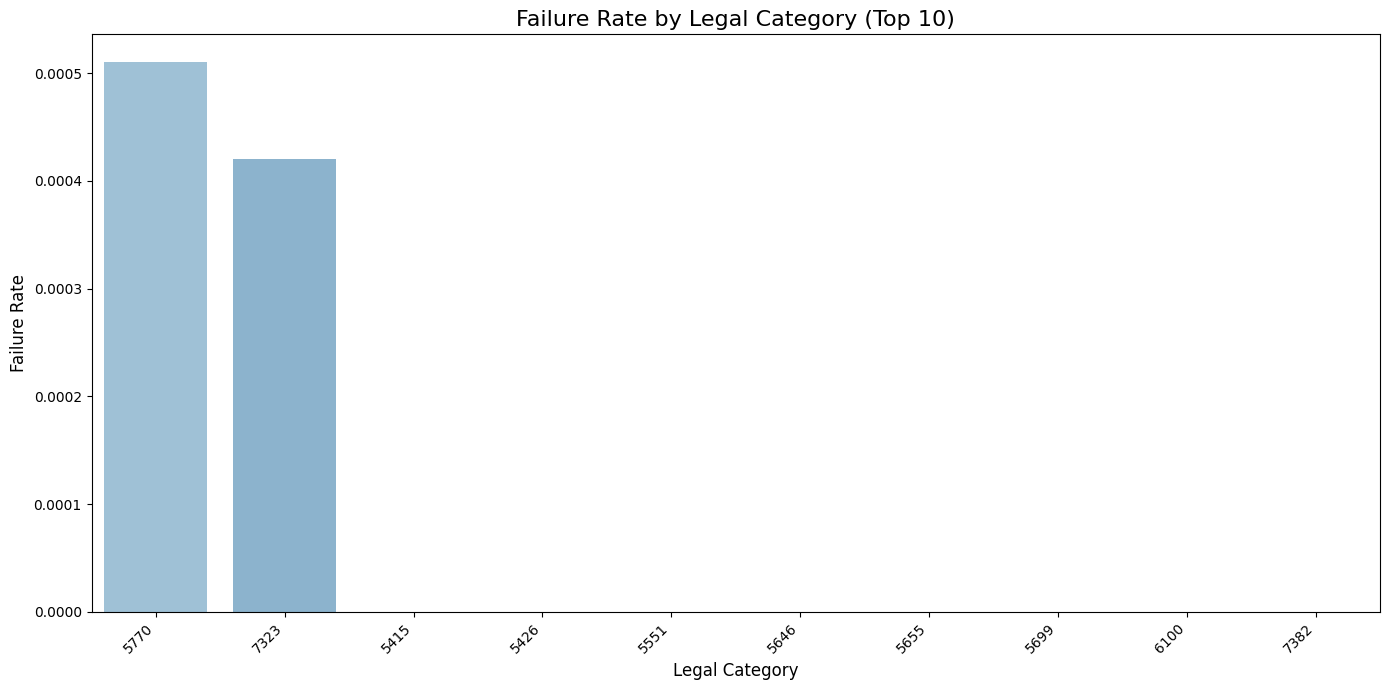

In [26]:
# --- Graph 3: Failure Rate by Legal Category (Top 10) ---
plt.figure(figsize=(14, 7))
top_cats = df_demo["categorieJuridiqueUniteLegale"].value_counts().head(10)["categorieJuridiqueUniteLegale"]
cat_data = df_demo.filter(pl.col("categorieJuridiqueUniteLegale").is_in(top_cats)).to_pandas()
order_jur = cat_data.groupby('categorieJuridiqueUniteLegale')['is_failed_in_3y'].mean().sort_values(ascending=False).index
sns.barplot(x='categorieJuridiqueUniteLegale', y='is_failed_in_3y', data=cat_data, order=order_jur, palette='Blues_d', errorbar=None)
plt.title('Failure Rate by Legal Category (Top 10)', fontsize=16)
plt.ylabel('Failure Rate', fontsize=12)
plt.xlabel('Legal Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('graph_3_failure_by_legal_category.png')
plt.show()

/var/folders/78/l_4xwnr90kd9z9r2bqrlqkqw0000gn/T/ipykernel_1591/3856135548.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='trancheEffectifsUniteLegale', y='is_failed_in_3y', data=eff_data, order=order_eff, palette='Reds_d', errorbar=None)


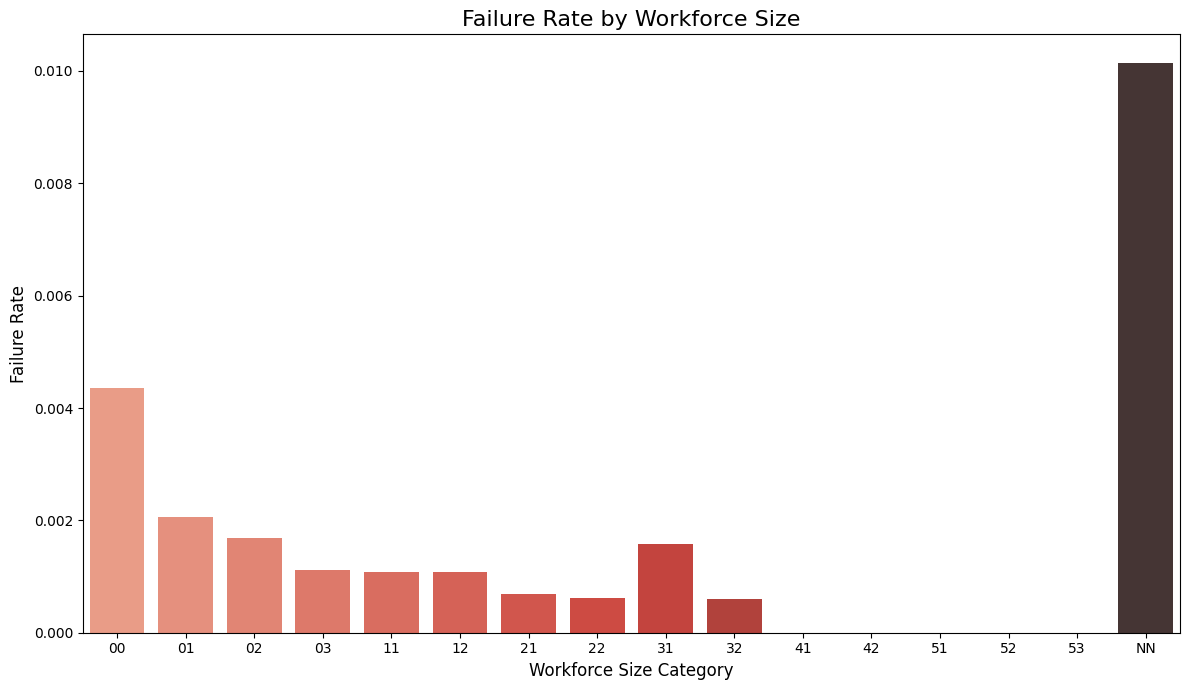

In [30]:
plt.figure(figsize=(12, 7))
eff_data = df_demo.sort("trancheEffectifsUniteLegale").to_pandas()
order_eff = sorted(eff_data['trancheEffectifsUniteLegale'].unique())
sns.barplot(x='trancheEffectifsUniteLegale', y='is_failed_in_3y', data=eff_data, order=order_eff, palette='Reds_d', errorbar=None)
plt.title('Failure Rate by Workforce Size', fontsize=16)
plt.ylabel('Failure Rate', fontsize=12)
plt.xlabel('Workforce Size Category', fontsize=12)
plt.tight_layout()
plt.savefig('graph_4_failure_by_workforce.png')
plt.show()

/var/folders/78/l_4xwnr90kd9z9r2bqrlqkqw0000gn/T/ipykernel_1591/211205287.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='departement', y='is_failed_in_3y', data=risky_depts_pl, palette='Purples_d')


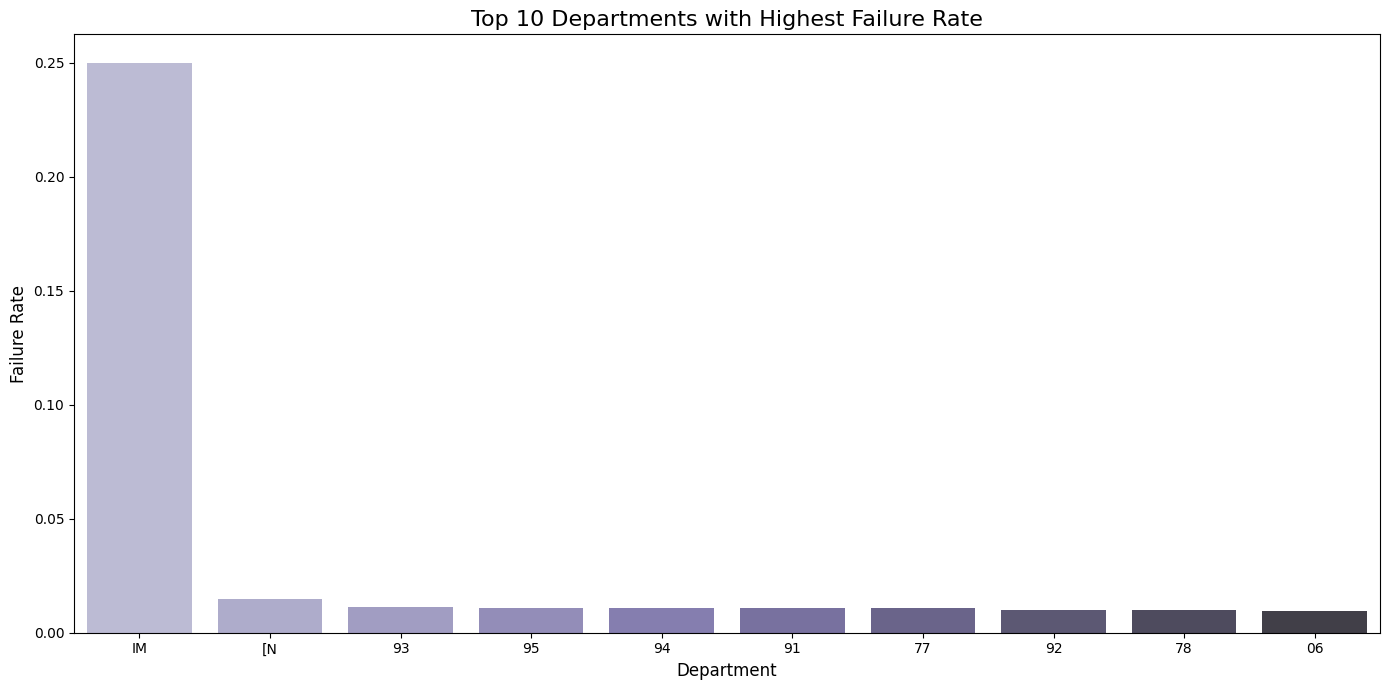

In [32]:
# --- Graph 5: Top 10 Riskiest Departments ---
plt.figure(figsize=(14, 7))
risky_depts_pl = (
    df_demo.group_by("departement")
    .agg(pl.col("is_failed_in_3y").mean())
    .sort("is_failed_in_3y", descending=True)
    .head(10)
).to_pandas()
sns.barplot(x='departement', y='is_failed_in_3y', data=risky_depts_pl, palette='Purples_d')
plt.title('Top 10 Departments with Highest Failure Rate', fontsize=16)
plt.ylabel('Failure Rate', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.tight_layout()
plt.savefig('graph_5_failure_by_department.png')
plt.show()

---

# EDA Bilan

In [7]:
import polars as pl
import pyarrow.parquet as pq
import sys

filepath = "../Data/processed/sirene_bilan.parquet" 

print("--- Début de la lecture 'bypass' ---")

try:
    print(f"Lecture du fichier via PyArrow : {filepath}")
    table_arrow = pq.read_table(
        filepath,
    )
    
    print("Conversion de la table PyArrow en DataFrame Polars...")
    df_bilan = pl.from_arrow(table_arrow)
    
    print("--- SUCCÈS ! ---\n")
    print("Le DataFrame est maintenant dans Polars, prêt pour la transformation.")
    print(df_bilan.head())

except Exception as e:
    print(f"\n--- ERREUR ---", file=sys.stderr)
    print(f"Impossible de lire le fichier, même avec PyArrow : {e}", file=sys.stderr)

--- Début de la lecture 'bypass' ---
Lecture du fichier via PyArrow : ../Data/processed/sirene_bilan.parquet
Conversion de la table PyArrow en DataFrame Polars...
--- SUCCÈS ! ---

Le DataFrame est maintenant dans Polars, prêt pour la transformation.
shape: (5, 21)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ siren     ┆ date_clot ┆ CJCK_Tota ┆ EG_Impots ┆ … ┆ ratio_cap ┆ ratio_tre ┆ ratio_res ┆ ratio_re │
│ ---       ┆ ure_exerc ┆ lActifBru ┆ Taxes     ┆   ┆ itaux_pro ┆ sorerie   ┆ ultat_fin ┆ sultat_e │
│ str       ┆ ice       ┆ t         ┆ ---       ┆   ┆ pres      ┆ ---       ┆ ancier    ┆ xception │
│           ┆ ---       ┆ ---       ┆ i32       ┆   ┆ ---       ┆ f64       ┆ ---       ┆ nel      │
│           ┆ date      ┆ i32       ┆           ┆   ┆ f64       ┆           ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ f64      │
╞═══════════╪═══════════╪══